In [ ]:
two concimport torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 59 * 59, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 5),
        )

    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


batch_size = 128
learning_rate = 0.001
num_epochs = 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, folder1, folder2, csv_file, transform=None):
        self.folder1 = folder1
        self.folder2 = folder2
        self.csv_data = pd.read_csv(csv_file)
        self.transform = transform

    def __getitem__(self, index):
        img_name = self.csv_data.iloc[index, 0]
        img1_path = os.path.join(self.folder1, img_name)
        img2_path = os.path.join(self.folder2, img_name)
        label = torch.tensor(self.csv_data.iloc[index, 1], dtype=torch.float32)

        img1 = Image.open(img1_path)#.convert('L')
        img2 = Image.open(img2_path)#.convert('L')

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label

    def __len__(self):
        return len(self.csv_data)


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [ ]:
batch_size = 32

train_dataset = SiameseDataset(folder1='/content/drive/MyDrive/4th_Semester/Capstone/enhanced_train_f/',
                               folder2='/content/drive/MyDrive/4th_Semester/Capstone/resize_train_f/',
                               csv_file='/content/drive/MyDrive/4th_Semester/Capstone/Code/labels.csv',
                               transform=transform)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True)

In [ ]:
for i in range(min(10, len(train_dataset))):
    img1, img2, label = train_dataset[i]
    print(f"Sample {i + 1} - Image1: {img1.shape}, Image2: {img2.shape}, Label: {label.item()}")


Sample 1 - Image1: torch.Size([3, 256, 256]), Image2: torch.Size([3, 256, 256]), Label: 0.0
Sample 2 - Image1: torch.Size([3, 256, 256]), Image2: torch.Size([3, 256, 256]), Label: 0.0
Sample 3 - Image1: torch.Size([3, 256, 256]), Image2: torch.Size([3, 256, 256]), Label: 0.0
Sample 4 - Image1: torch.Size([3, 256, 256]), Image2: torch.Size([3, 256, 256]), Label: 0.0
Sample 5 - Image1: torch.Size([3, 256, 256]), Image2: torch.Size([3, 256, 256]), Label: 0.0
Sample 6 - Image1: torch.Size([3, 256, 256]), Image2: torch.Size([3, 256, 256]), Label: 0.0
Sample 7 - Image1: torch.Size([3, 256, 256]), Image2: torch.Size([3, 256, 256]), Label: 0.0
Sample 8 - Image1: torch.Size([3, 256, 256]), Image2: torch.Size([3, 256, 256]), Label: 1.0
Sample 9 - Image1: torch.Size([3, 256, 256]), Image2: torch.Size([3, 256, 256]), Label: 0.0
Sample 10 - Image1: torch.Size([3, 256, 256]), Image2: torch.Size([3, 256, 256]), Label: 1.0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
best_loss = 0.17
for epoch in range(num_epochs):
    total_loss = 0.0
    for i, (img1, img2, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label)
        output1, output2, label = output1.to(device), output2.to(device), label.to(device)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_dataloader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss}')

    if average_loss < best_loss:
        best_loss = average_loss
        torch.save(model.state_dict(), f'/content/drive/MyDrive/4th_Semester/Capstone/best_model_weights.pth')
        print('Model weights saved!')

Epoch 1/10, Average Loss: 0.5336124161356374
Model weights saved!
Epoch 2/10, Average Loss: 0.3835544243454933
Model weights saved!
Epoch 3/10, Average Loss: 0.4216969788858765
Epoch 4/10, Average Loss: 0.34273953375063443
Model weights saved!
Epoch 5/10, Average Loss: 0.31722418211008374
Model weights saved!
Epoch 6/10, Average Loss: 0.2831955992077526
Model weights saved!
Epoch 7/10, Average Loss: 0.27398041522032335
Model weights saved!
Epoch 8/10, Average Loss: 0.21717090781189893
Model weights saved!
Epoch 9/10, Average Loss: 0.19553669932249346
Model weights saved!
Epoch 10/10, Average Loss: 0.1785514033938709
Model weights saved!


In [ ]:
model = SiameseNetwork()
model.load_state_dict(torch.load('/content/drive/MyDrive/4th_Semester/Capstone/best_model_weights.pth', map_location=torch.device('cpu')))
model.eval()

val_dataset = SiameseDataset(folder1='/content/drive/MyDrive/4th_Semester/Capstone/resize_val_f',
                              folder2='/content/drive/MyDrive/4th_Semester/Capstone/enhanced_val_f',
                              csv_file='/content/drive/MyDrive/4th_Semester/Capstone/Code/labels_val.csv',
                              transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)

correct_predictions = 0
total_samples = 0
threshold = 2
d = []
predictions = []

with torch.no_grad():
    for img1, img2, labels in val_dataloader:
        #img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        output1, output2 = model(img1, img2)

        distances = nn.functional.pairwise_distance(output1, output2)
        d.append(distances)
        predicted_labels = (distances > threshold).float()
        predictions.append(predicted_labels)

        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

accuracy = correct_predictions / total_samples
print(f'Validation Accuracy: {accuracy * 100:.2f}%')


Validation Accuracy: 82.11%


In [ ]:
import csv

def write_list_to_csv(output_file, data_list):
    with open(output_file, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Column'])

        for item in data_list:
            csv_writer.writerow([item])

output_file_path = '/content/drive/MyDrive/4th_Semester/Capstone/file1.csv'

write_list_to_csv(output_file_path, predictions)


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd


csv_file_path = '/content/drive/MyDrive/4th_Semester/Capstone/Code/labels_val.csv'

df = pd.read_csv(csv_file_path)

all_labels = df['1'].to_numpy().astype(int)
all_labels = all_labels.tolist()

predictions = torch.cat(predictions).numpy()

predicted_labels = predictions.tolist()
print(all_labels[:5], predicted_labels[:5])

conf_matrix = confusion_matrix(all_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nAccuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


[0, 1, 0, 0, 0] [0.0, 1.0, 0.0, 0.0, 0.0]
Confusion Matrix:
[[771  15]
 [190 170]]

Accuracy: 82.11%
Precision: 0.9189
Recall: 0.4722
F1 Score: 0.6239


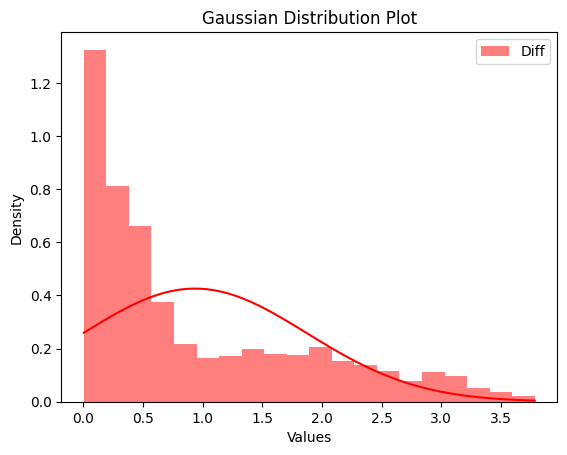

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data3 = [item for sublist in d for item in sublist.numpy()]

hist3, bin_edges3 = np.histogram(data3, bins=20, density=True)

mu3, sigma3 = np.mean(data3), np.std(data3)

x3 = np.linspace(min(data3), max(data3), 100)
y3 = (1 / (sigma3 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x3 - mu3) / sigma3) ** 2)

plt.hist(data3, bins=20, density=True, alpha=0.5, color='red', label='Diff')
plt.plot(x3, y3, color='red')

plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Gaussian Distribution Plot')

plt.legend()
plt.show()
